## 49 - Satellite Data with CLASS Part 6

[Youtube](https://www.youtube.com/watch?v=mfBpAV2Zd6w)

[GOES Calibration - Conversion of GVAR Infrared Data to
Scene Radiance or Temperature](https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html)

[NOAA CLASS](https://www.avl.class.noaa.gov/saa/products/welcome)

Make sure: User preferences > GVAR Data Extraction Preferences > GVAR_IMG > NetCDF  &nbsp; (Metpy Monday #44)

How to download files &nbsp; (Metpy Monday #45) <br/>
Quick summary: <br/>

Search Data > Environmental Data from Geostationary Satellites > GOES Satellite Data - Imager (GVAR_IMG) <br/>
Set options:
- Start Date: 27 April 2011 19:00:00 
- End Date: 27 April 2011 20:59:59 
- Coverage: Continental United States
- Satellite Schedule: Routine, Rapid Scan Operation
- Satellite: GOES-13

... or ... <br/>

[File directory](https://download.avl.class.noaa.gov/download/8369075216/001)

file names: 
- goes13.2011.117.200229.BAND_01.nc
- goes13.2011.117.200229.BAND_02.nc
- goes13.2011.117.200229.BAND_03.nc
- goes13.2011.117.200229.BAND_04.nc
- goes13.2011.117.200229.BAND_06.nc

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np

In [2]:
file_ir = 'satellite_data/goes13.2011.117.200229.BAND_04.nc'

In [3]:
ds_ir = Dataset(file_ir, 'r')

In [4]:
list(ds_ir.variables)

['version',
 'sensorID',
 'imageDate',
 'imageTime',
 'startLine',
 'startElem',
 'time',
 'dataWidth',
 'lineRes',
 'elemRes',
 'prefixSize',
 'crDate',
 'crTime',
 'bands',
 'auditTrail',
 'data',
 'lat',
 'lon']

In [5]:
ir_10bit = ds_ir.variables['data'][0]/32

In [6]:
lat_ir = np.ma.masked_values(ds_ir.variables['lat'][:], 2.14329e+09)
lon_ir = np.ma.masked_values(ds_ir.variables['lon'][:], 2.14329e+09)

In [7]:
ir_masked = np.ma.masked_array(ir_10bit, mask = lat_ir.mask)

In [8]:
# Step I. Conversion of Imager GVAR Count to Scene Radiance
# Table 1-2. GOES-12 and -O Imager Scaling Coefficients - Channel 4
m_ir = 5.2285
b_ir = 15.6854

R_ir = (ir_masked - b_ir)/m_ir


In [9]:
# Step II. Conversion of Imager GVAR count to Temperature

# Inverse Planck function constants
c1 = 1.191066e-5
c2 = 1.438833

# GOES-13 coefficients for Channel 4
n_ir = 937.23

a_ir = -0.386043

b_ir = 1.001298

T_eff_ir = (c2 * n_ir)/(np.log(1 + (c1 * n_ir**3)/R_ir))

BT_ir = a_ir + b_ir * T_eff_ir
BT_ir.max()

/tmp/ipykernel_143343/367648796.py:14: RuntimeWarning: invalid value encountered in log
  T_eff_ir = (c2 * n_ir)/(np.log(1 + (c1 * n_ir**3)/R_ir))


331.24628

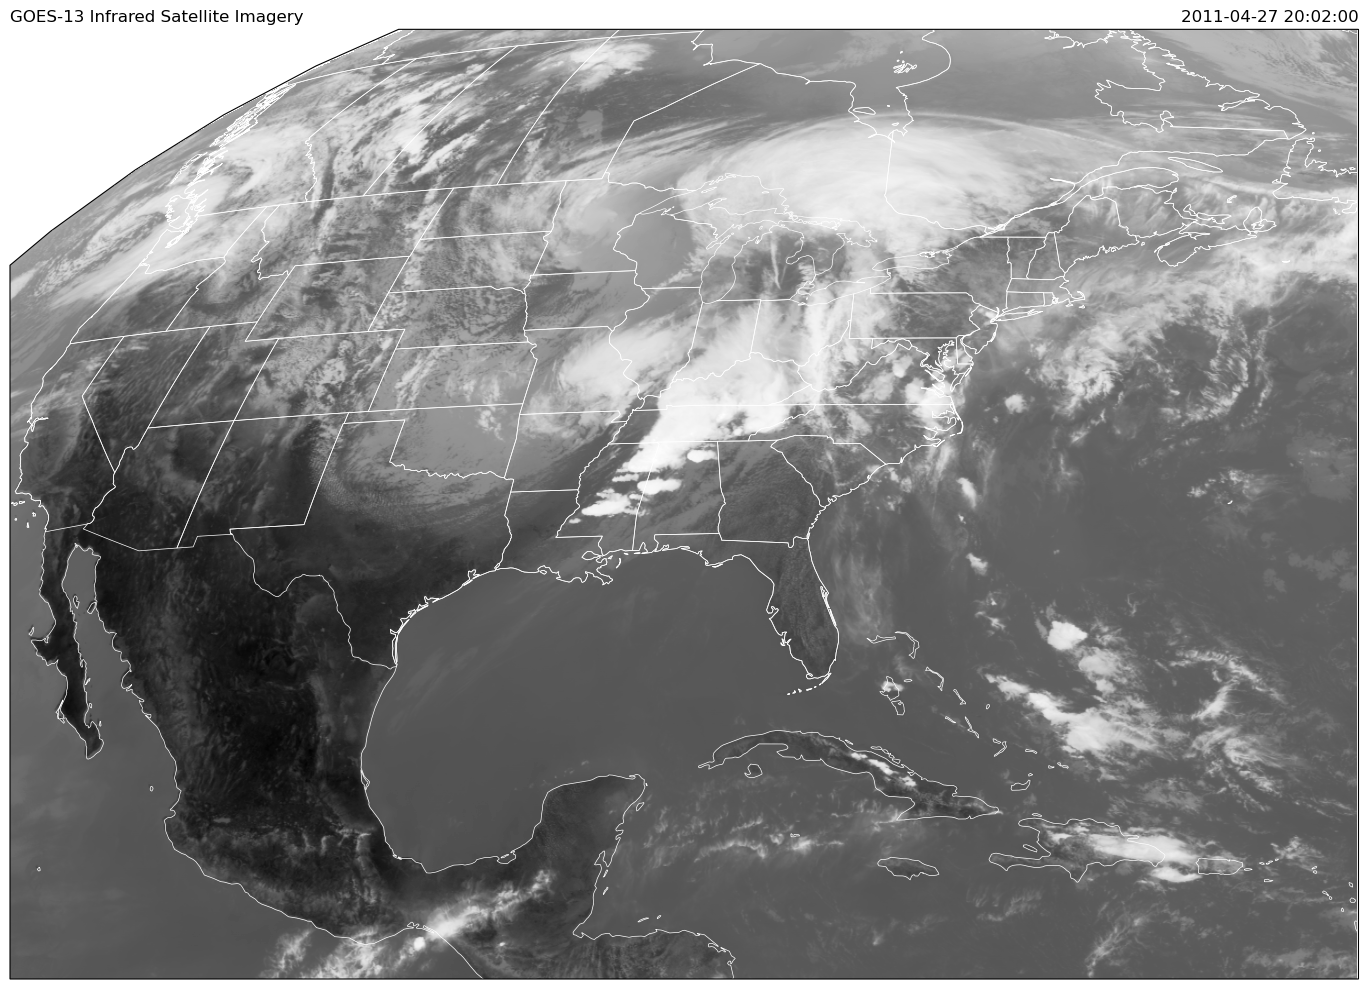

In [10]:
vtime = num2date(ds_ir.variables['time'][:], units = ds_ir.variables['time'].units)

mapcrs = ccrs.Geostationary(central_longitude = -75)

ilon_min = np.unravel_index(np.argmin(lon_ir), lon_ir.shape)
ilon_max = np.unravel_index(np.argmax(lon_ir), lon_ir.shape)

ilat_min = np.unravel_index(np.argmin(lat_ir), lat_ir.shape)
ilat_max = np.unravel_index(np.argmax(lat_ir), lat_ir.shape)

LONpt0 = mapcrs.transform_point(lon_ir[ilon_min], lat_ir[ilon_min], ccrs.Geodetic())[0]
LONpt1 = mapcrs.transform_point(lon_ir[ilon_max], lat_ir[ilon_max], ccrs.Geodetic())[0]

LATpt0 = mapcrs.transform_point(lon_ir[ilat_min], lat_ir[ilat_min], ccrs.Geodetic())[1]
LATpt1 = mapcrs.transform_point(lon_ir[ilat_max], lat_ir[ilat_max], ccrs.Geodetic())[1]

fig = plt.figure(1, figsize = (19, 10))
ax = plt.subplot(111, projection = mapcrs)
img = ax.imshow(BT_ir, cmap = 'Greys', origin = 'upper', extent = (LONpt0, LONpt1, LATpt0, LATpt1))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor = 'white', linewidth = 0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = 'white', linewidth = 0.5)

plt.title(vtime[0], loc = 'right')
plt.title('GOES-13 Infrared Satellite Imagery', loc = 'left')

plt.tight_layout()
plt.show()

From Metpy Monday #51:

[Metpy API Colortables](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.ctables.html)

In [11]:
from metpy.plots import ctables

ir_cmap = ctables.registry.get_colortable('ir_drgb_r')
ir_cmap.set_under('k')

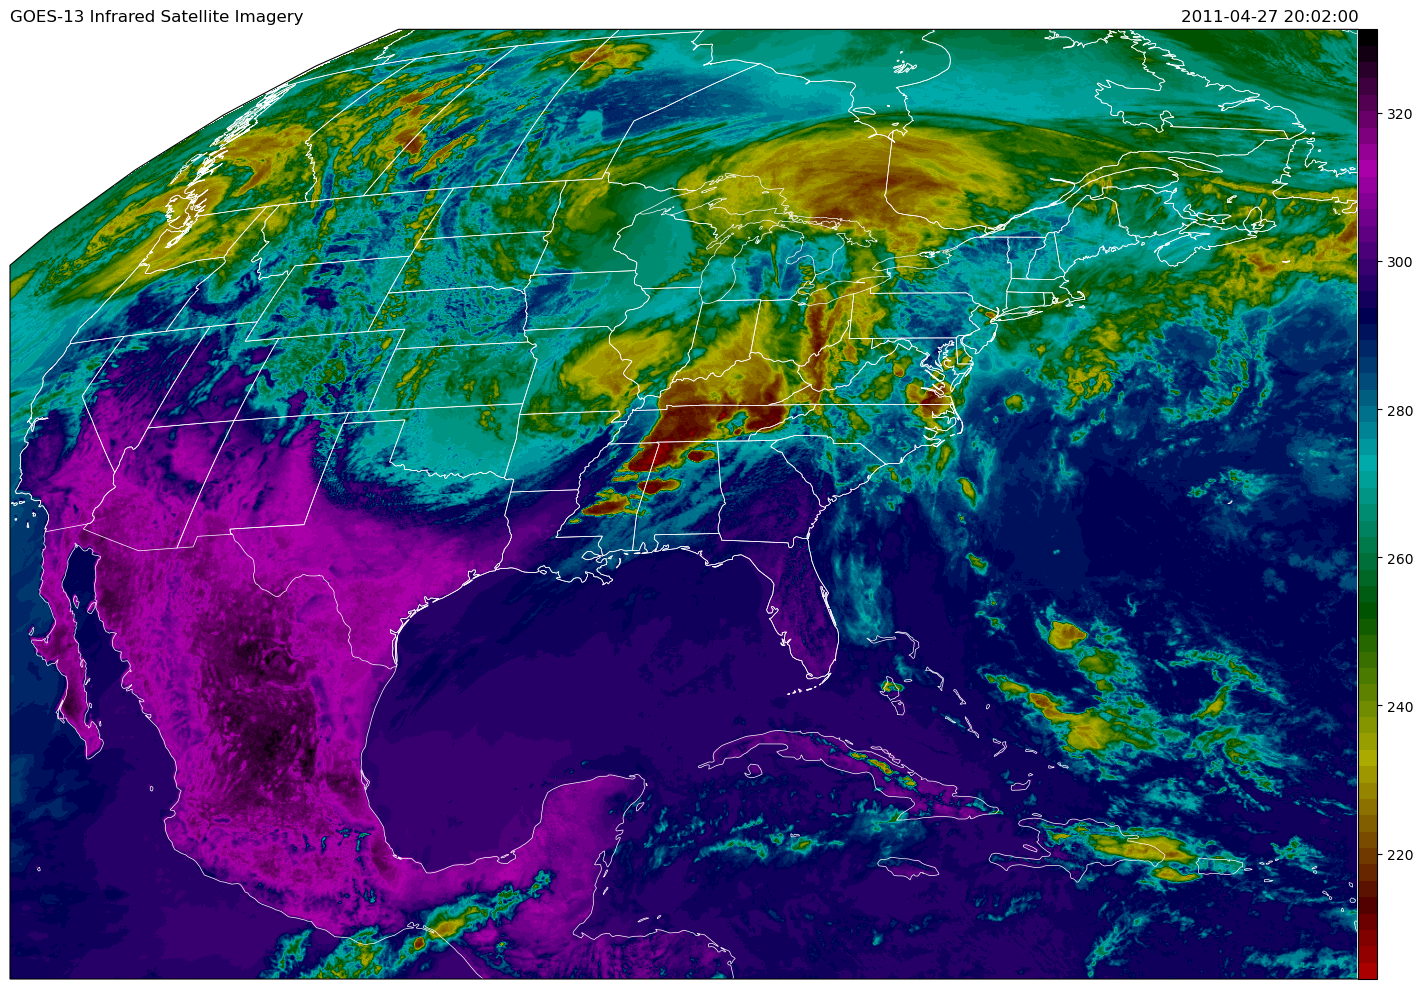

In [12]:
fig = plt.figure(1, figsize = (19, 10))
ax = plt.subplot(111, projection = mapcrs)

img = ax.imshow(BT_ir, cmap = ir_cmap, origin = 'upper', extent = (LONpt0, LONpt1, LATpt0, LATpt1))
plt.colorbar(img, orientation = 'vertical', pad = 0, aspect = 50)

ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor = 'white', linewidth = 0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = 'white', linewidth = 0.5)

plt.title(vtime[0], loc = 'right')
plt.title('GOES-13 Infrared Satellite Imagery', loc = 'left')

plt.tight_layout()
plt.show()